# Mini Project 1: Deep Q-learning for Epdicemic Mitigation

**Amin Asadi Sarijalou**: **347814**

**Ilker Gül**: **353296**

## Introduction

### Description

### Environment Setup

1. Install conda if you don't have it (see [the conda documentation here](https://conda.io/projects/conda/en/latest/user-guide/install/index.html) to learn how to do so)
2. Create a dedicated environment and install the packages in the environment by running the following commands:
```
conda create -n epi
conda activate epi
conda install pytorch torchvision torchaudio -c pytorch
conda install numpy networkx matplotlib pyyaml jupyter tqdm pandas
pip install gym
pip install ipykernel

### Importing necessary libraries

In [6]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

explain what you have done

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


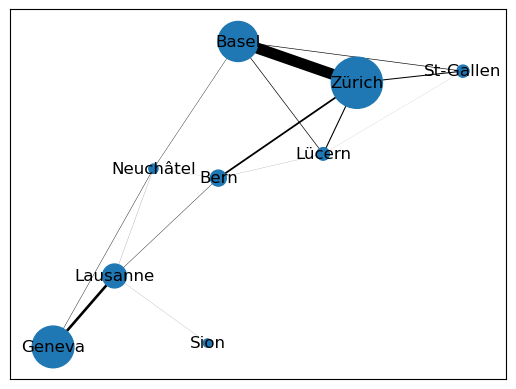

In [7]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

In [34]:
### Define the dynamics of the environment
### can be reused by all problems because env.reset() will reset the dynamics as well
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

## Question 1

#### Actions

- 'confinement': Represents imposing confinement or lockdown measures. False indicates it is not being imposed.
- 'isolation': Represents enforcing isolation measures. False indicates it is not being enforced.
- 'hospital': Represents admitting patients to hospitals. False indicates this action is not being taken.
- 'vaccinate': Represents administering vaccinations. False indicates no vaccinations are being given.

#### helper functions

In [101]:
from matplotlib.ticker import MultipleLocator

# Parse the logs
def parse_logs(log: Log, dyn: ModelDynamics):
    total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    
    return total, cities, actions

# Plot 1: s[w], e[w], i[w], r[w], d[w] over time
def plot_all_totals(total: dict, axis: plt.Axes):
    # plt.figure()
    for y in total.values():
        axis.plot(y)
    axis.legend(total.keys())
    axis.set_xlabel('Weeks')
    axis.set_ylabel('Number of people in each state')
    axis.set_title('Total Population Over Time')

# Plot 2: i[w], d[w] over time
def plot_infected_dead(total: dict, axis: plt.Axes):
    # plt.figure()
    for state in ['infected', 'dead']:
        axis.plot(total[state])
    axis.legend(['infected', 'dead'])
    axis.set_xlabel('Weeks')
    axis.set_ylabel('Number of people')
    axis.set_title('Infected and Dead Population Over Time')

# Plot 3: i[w], d[w] over time, one subplot per city
def plot_infected_dead_per_city(dyn: ModelDynamics, cities: dict, axis: plt.Axes):
    # n_cities = len(dyn.cities)
    # fig, axes = plt.subplots(3, 3, figsize=(12, n_cities))
    # axes = axes.flatten()
    # for i, city in enumerate(dyn.cities):
    #     for state in ['infected', 'dead']:
    #         axes[i].plot(cities[city][state])
    #     axes[i].legend(['infected', 'dead'])
    #     axes[i].set_title(f'City {city}')
    #     axes[i].set_xlabel('Weeks')
    #     axes[i].set_ylabel('Number of people')
    # fig.suptitle('Infected and Dead Population Over Time per City')

    [ax.plot(cities[c]['infected']) for c, ax in axis.items()]
    [ax.plot(cities[c]['dead']) for c, ax in axis.items()]
    [ax.set_ylabel(c) for c, ax in axis.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in axis.items()]
    axis['Zürich'].set_xlabel('time (in weeks)')
    axis['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

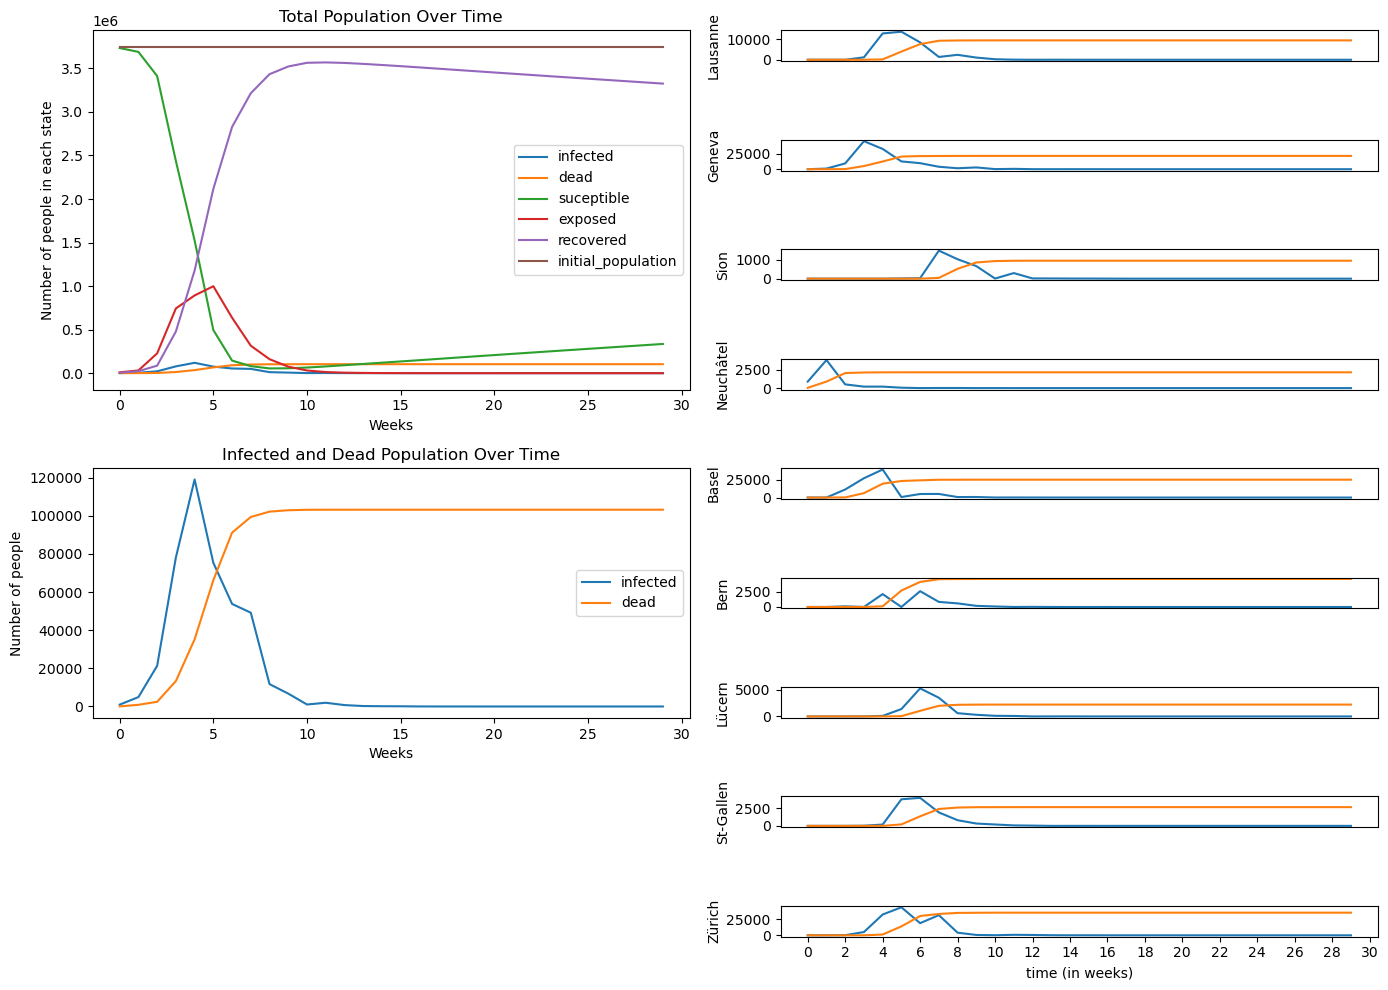

In [104]:
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

NULL_ACTION = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

# Run the simulation
seed = 353296
log = []
finished = False
obs, info = env.reset(seed)
for t in range(30):
    obs, R, finished, info = env.step(NULL_ACTION)
    log.append(info)
    if finished:
        break

# parse the logs
total, cities, actions = parse_logs(log, dyn)

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
# ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}


## 1.a
#1.a.1
plot_all_totals(total, ax_leftstate)

#1.a.2
plot_infected_dead(total, ax_leftobs)

#1.a.3
plot_infected_dead_per_city(dyn, cities, ax_right)

plt.tight_layout()
plt.show()


In [9]:
for state in total.keys():
    print(state)
    print(total[state])

infected
[   968   4926  21314  78148 119039  75341  53785  49172  11732   6746
   1039   1956    735    236    137    102     26      3      2      0
      0      0      0      0      0      0      0      0      0      0]
dead
[    40    888   2447  13315  35220  66201  91148  99378 102166 102904
 103143 103173 103179 103180 103180 103180 103180 103180 103180 103180
 103180 103180 103180 103180 103180 103180 103180 103180 103180 103180]
suceptible
[3733920 3689866 3412391 2436453 1524878  495295  144348   80521   54583
   56238   64651   77354   91357  105992  120468  134727  149244  163923
  178809  193297  207864  222369  236670  251071  265240  279244  293331
  307378  321413  335483]
exposed
[  9959  31394 227411 743373 892711 998407 636977 315242 160539  74908
  30593  12807   5943   2906   1262    520    258    123     61     30
     14      6      3      1      0      0      0      0      0      0]
recovered
[   4945   22756   86399  478669 1179393 2116042 2827741 3215118 34336

#### **DISCUSSION**

**INFECTED**:

**DEAD**:

**SUSCEPTIBLE**:The susceptible population comprises individuals who have not contracted the infection but could become infected upon exposure to the virus. As the outbreak advances, the susceptible population typically declines. This happens because more people are exposed to the virus and then transition to other states, such as infected, recovered, or dead.

Analyzing the provided data, you can observe the following trend:

- At the beginning of the epidemic, the number of susceptible individuals is high (3,733,920).
- As the epidemic progresses, more people become exposed and infected, so the susceptible population decreases.
- The susceptible population reaches its lowest point (54,583) when the infected population is at its peak (119,039). This suggests that a large portion of the susceptible population has either been infected, recovered, or died.
- After the epidemic peak, the susceptible population starts to increase again as the number of new infections decreases. This can be attributed to individuals recovering or dying, resulting in fewer infected people to spread the virus to susceptible individuals.


**EXPOSED**:

**RECOVERED**:


## Question 2

#### Part A

Implement Pr. Russo’s Policy as a python class (we recommend that you subclass the Agent abstract class provided with the project files, and as is demonstrated in the tutorial notebook). Run the epidemic simulation for one episode using Pr. Russo’s Policy to pick actions and produce four plots:

#### Helper functions

In [135]:
# parameters for action_preprocessor
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

# parameter for observation_preprocessor
SCALE = 100

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    ## similar to tutorial
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    out = torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)
    
    ## recommended by the project description to pass the observation tensor through (.)^0.25 to avoid very small values in the tensor
    return out**(0.25)

def plot_does_confine(actions: np.array, axis: plt.Axes):
    axis.imshow(np.expand_dims(actions, 0).astype(np.uint8), aspect='auto')    
    axis.set_title('Actions')
    axis.set_xticks(np.arange(0, len(actions), 2))
    axis.set_yticks([0])
    axis.set_yticklabels(['confinement'])
    axis.set_xlabel('time (in weeks)')


In [136]:
class RussosAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Pr. Russos' agent: Confines the whole country if the number of infected people
        is above 20,000 if not already done
        """
        self.week_counter = 0
        self.in_confinement = False
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the routine for optimizing the model
        pass
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        if self.in_confinement and self.week_counter < 4:
            self.week_counter += 1
            return NULL_ACTION
        elif self.in_confinement and self.week_counter >= 4:
            self.week_counter = 0
            self.in_confinement = False

        num_infected = obs.total.infected[-1]

        if num_infected > 20000:
            self.in_confinement = True
            action = action_preprocessor(ACTION_CONFINE, self.env.dyn)
        else:
            action = NULL_ACTION

        return action

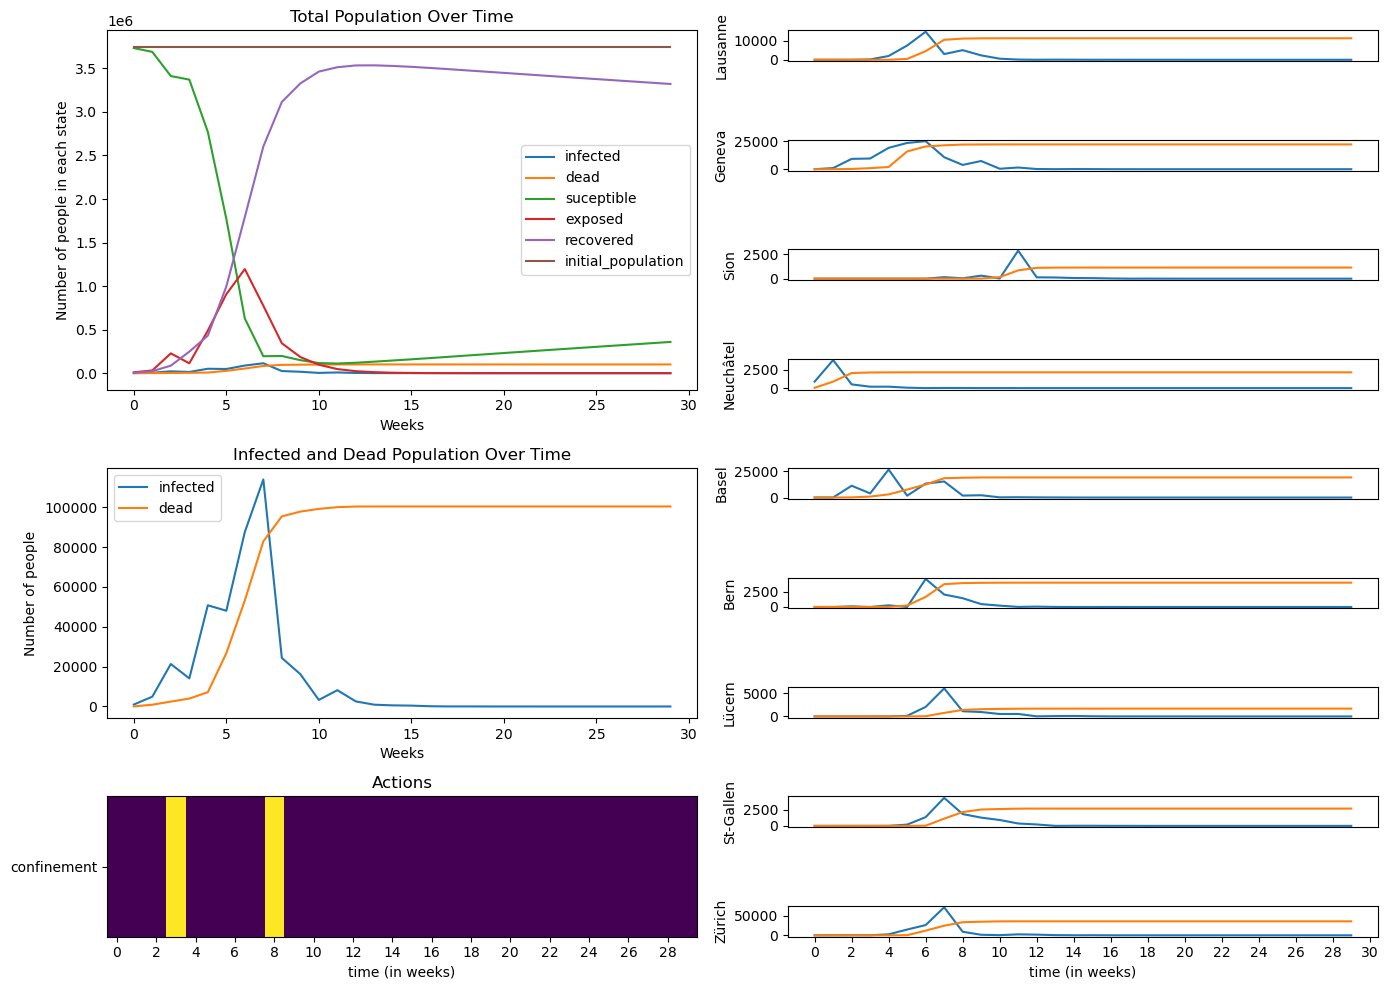

In [137]:
agent = RussosAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    
total, cities, actions = parse_logs(log, dyn)

##2.a
fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

#2.a.1
plot_all_totals(total, ax_leftstate)

#2.a.2
plot_infected_dead(total, ax_leftobs)

#2.a.3
plot_infected_dead_per_city(dyn, cities, ax_right)

#2.a.4
plot_does_confine(actions['confinement'], ax_leftactions)

plt.tight_layout()
plt.show()

In [72]:
def evaluate_agent(agent: Agent, env: Env, n_episodes: int):
    num_total_confined = []
    cumulative_reward = []
    num_total_confined_days = []

    for _ in range(n_episodes):
        log = []
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        agent.epsilon = 0

        cum_R = 0
        total_deaths = 0
        num_confined_weeks = 0
        while not finished:
            action = agent.act(obs)
            obs, R, finished, info = env.step(action)
            log.append(info)
            cum_R += R
            total_deaths += info.total.dead
            if action['confinement']:
                num_confined_weeks += 1

        cumulative_reward.append(cum_R.item())
        num_total_confined.append(total_deaths)
        num_total_confined_days.append(num_confined_weeks * 7)
    
    return cumulative_reward, num_total_confined, num_total_confined_days

In [73]:
cumulative_reward, num_total_confined, num_total_confined_days = evaluate_agent(agent, env, 50)

Text(0, 0.5, 'Frequency')

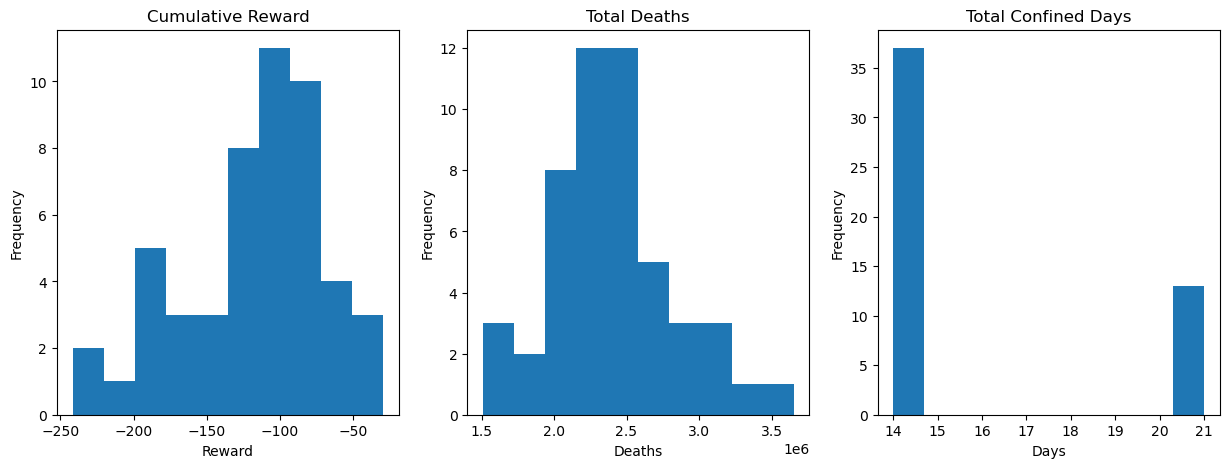

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(cumulative_reward)
axes[0].set_title('Cumulative Reward')
axes[0].set_xlabel('Reward')
axes[0].set_ylabel('Frequency')
axes[1].hist(num_total_confined)
axes[1].set_title('Total Deaths')
axes[1].set_xlabel('Deaths')
axes[1].set_ylabel('Frequency')
axes[2].hist(num_total_confined_days)
axes[2].set_title('Total Confined Days')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Frequency')

## Question 3

In [77]:
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [83]:
import torch.optim as optim
import torch.nn.functional as F

In [78]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.hidden_layer_1 = nn.Linear(n_observations, 64)
        self.hidden_layer_2 = nn.Linear(64, 32)
        self.hidden_layer_3 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        x = self.output_layer(x)

        return x

In [ ]:
class DQNAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        DQN Agent
        """
        self.env = env

        # BATCH_SIZE is the number of transitions sampled from the replay buffer
        # GAMMA is the discount factor as mentioned in the previous section
        # EPS_START is the starting value of epsilon
        # EPS_END is the final value of epsilon
        # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
        # TAU is the update rate of the target network
        # LR is the learning rate of the ``AdamW`` optimizer
        BATCH_SIZE = 128
        GAMMA = 0.9
        EPS_START = 0.9
        EPS_END = 0.05
        EPS_DECAY = 1000
        TAU = 0.005
        LR = 5e-3

        # Get number of actions from gym action space
        n_actions = 2
        # Get the number of state observations
        obs, info = env.reset(seed)
        n_observations = len(obs)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(n_observations, n_actions).to(self.device)
        self.target_net = DQN(n_observations, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)


        self.steps_done = 0


        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def train(self):
        if torch.cuda.is_available():
            num_episodes = 600
        else:
            num_episodes = 50

        for _ in range(num_episodes):
            # Initialize the environment and get it's state
            state, info = env.reset(seed)
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                action = self.act(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    # episode_durations.append(t + 1)
                    # plot_durations()
                    break

                print('Complete')
                # plot_durations(show_result=True)
                plt.ioff()
                plt.show()

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        global steps_done
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:

# def select_action(state):



# episode_durations = []


# def plot_durations(show_result=False):
#     plt.figure(1)
#     durations_t = torch.tensor(episode_durations, dtype=torch.float)
#     if show_result:
#         plt.title('Result')
#     else:
#         plt.clf()
#         plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel('Duration')
#     plt.plot(durations_t.numpy())
#     # Take 100 episode averages and plot them too
#     if len(durations_t) >= 100:
#         means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         if not show_result:
#             display.display(plt.gcf())
#             display.clear_output(wait=True)
#         else:
#             display.display(plt.gcf())